<h1>Лабораторная работа 1</h1>
Енгоян Сергей А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br> 
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [6]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)
    a2 = np.random.uniform(0.5, 1.0)

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.sin(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        print('A =', a0, 'f =', a1, 'a2 =', a2)
        return result
    elif num == 2:
        for i in range(N):
            result.append(np.exp(0.1 * t[i]) + 2 * e[i])
        return result

A = 0.20585761378989575 f = 0.07410186122852701 a2 = 0.9605132949679258


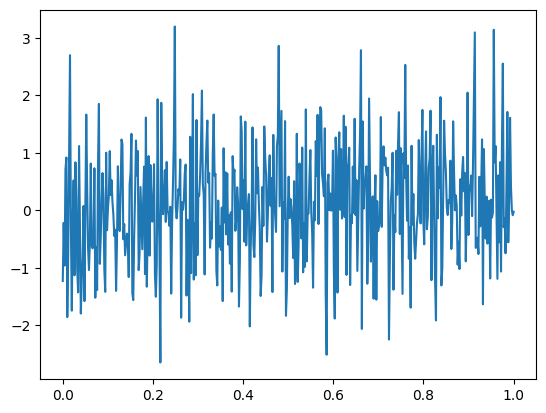

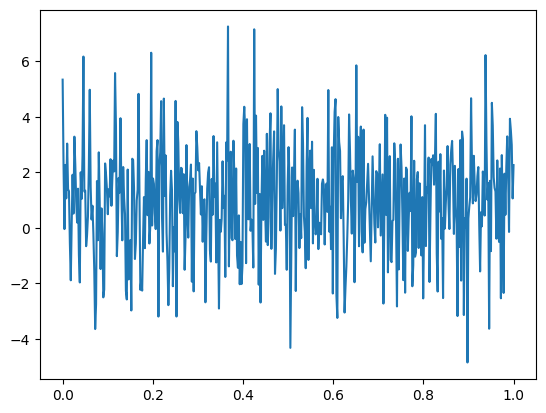

In [7]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [8]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [9]:
def diffs(X):
    X = np.array(X, dtype=float)
    N = len(X)

    diff_x = np.full(N, np.nan)  # разница с предыдущим
    diff_y = np.full(N, np.nan)  # разница с следующим

    # начиная со второго элемента до последнего, считаем разницу с предыдущим
    diff_x[1:-1] = X[1:-1] - X[0:-2]

    # начиная со второго до предпоследнего, считаем разницу с следующим
    diff_y[1:-1] = X[2:] - X[1:-1]

    return diff_x, diff_y 

In [10]:
def ellips(Y, PARAM):
    dx, dy = diffs(Y)

    # Очистка от NaN
    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    # Середина эллипса
    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    # Ковариационная матрица
    cov = np.cov(dx_clean, dy_clean)

    # Главные оси
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Размеры эллипса
    confidence_val = chi2.ppf(PARAM, df=2)
    width, heigth = 2 * np.sqrt(confidence_val * vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    el = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=heigth,
        angle=angle,
        edgecolor='r',
        facecolor='none',
        lw=2
    )

    # Махаланобисово расстояние
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # Отбор аномалий
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))
    outliers_mask = (mahal_sq > confidence_val) & in_quadrant

    # Координаты и индексы аномалий
    outlier_x = dx_clean[outliers_mask]
    outlier_y = dy_clean[outliers_mask]
    outlier_indices = np.where(mask)[0][outliers_mask]

    # Запись аномалий
    anomalies = []
    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        anomalies.append(idx)
        # print(f"{idx} : {Y[idx]} {x} {y}")

    fig, ax = plt.subplots()
    ax.spines['left'].set_position(('data', mean_x))
    ax.spines['bottom'].set_position(('data', mean_y))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(outlier_x, outlier_y, color='orange', s=30, label='Аномалии')

    for x, y, idx in zip(outlier_x, outlier_y, outlier_indices):
        ax.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    ax.add_patch(el)
    ax.legend()
    plt.show()

    return anomalies

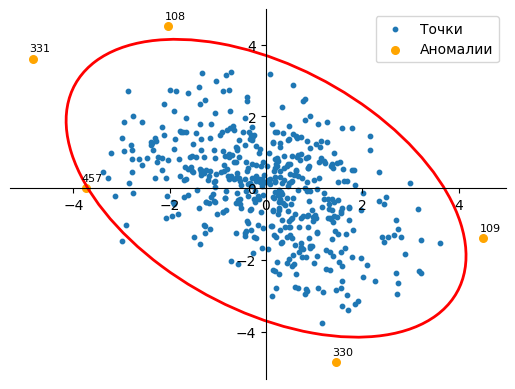

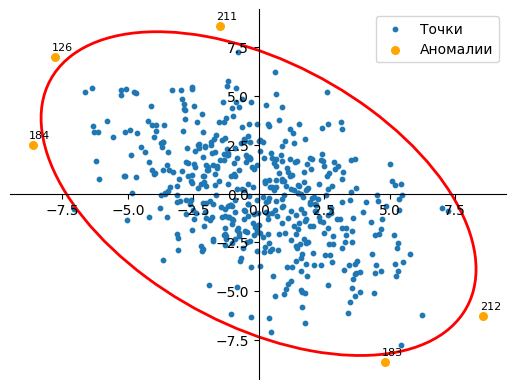

In [11]:
PARAM = 0.99

anom_y1 = ellips(y1, PARAM)

anom_y2 = ellips(y2, PARAM)

In [12]:
def smoothing(Y, anomalies):
    X = Y.copy()
    for i in anomalies:
        if i == 0:
            X[i] = (X[i+1] + X[i+2]) / 2
        elif i == len(X) - 1:
            X[i] = (X[i-1] + X[i-2]) / 2
        else:
            X[i] = (X[i-1] + X[i+1]) / 2
    return X

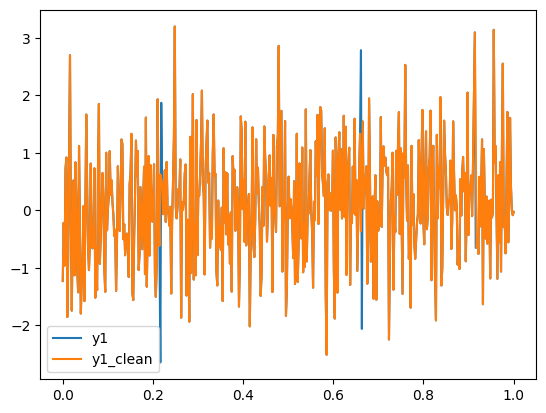

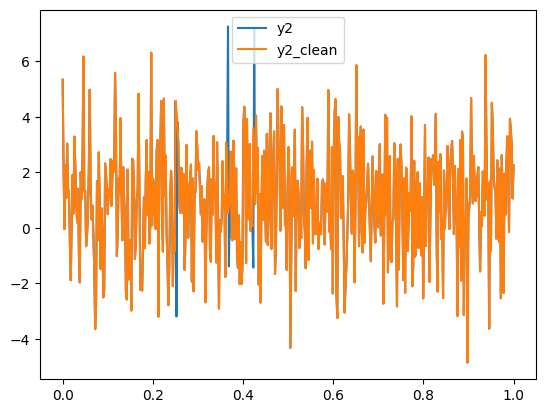

In [13]:
y1_clean = smoothing(y1, anom_y1)
y2_clean = smoothing(y2, anom_y2)

plt.plot(t, y1, label='y1')
plt.plot(t, y1_clean, label='y1_clean')
plt.legend()
plt.show()
plt.plot(t, y2, label='y2')
plt.plot(t, y2_clean, label='y2_clean')
plt.legend()
plt.show()

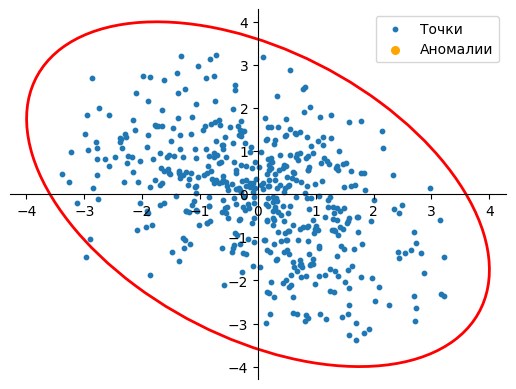

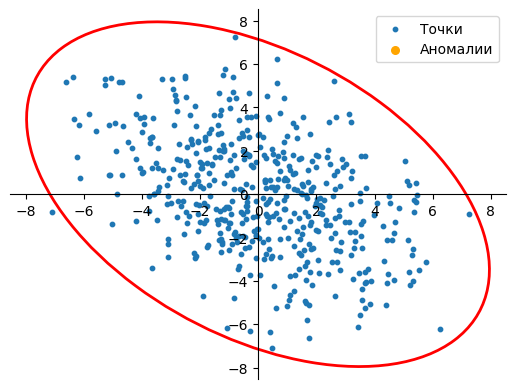

In [14]:
PARAM = 0.99

anom_y1 = ellips(y1_clean, PARAM)

anom_y2 = ellips(y2_clean, PARAM)

<h3>3) Исследование стационарности</h3>

In [15]:
def nums_max_series(X):
    # Нахождение кол-ва последовательностей и максимальной длины
    series, max_series = 1, 0
    current_length = 1

    for i in range(1, len(X)):
        if X[i] == X[i-1]:
            current_length += 1
        else:
            max_series = max(max_series, current_length)
            series += 1
            current_length = 1
    return series, max(max_series, current_length)

In [16]:
def median_test(Y):
    # Медианный тест
    test = []
    med = np.median(Y)
    for i in range(len(Y)):
        if Y[i] > med:
            test.append("+")
        elif Y[i] < med:
            test.append("-")
    
    series, max_series = nums_max_series(test)

    nu = 0.5 * (len(Y) + 2 - 1.96 * np.sqrt(len(Y) - 1))
    tau = 1.43 * np.log(len(Y) + 1)

    print(nu, series)
    print(tau, max_series)

    if series <= nu or max_series >= tau:
        return False
    else:
        return True

    

In [17]:
def means_50(Y):
    means = []
    for i in range(10):
        means.append(np.mean(Y[i*50:(i+1)*50]))
    return means

def vars_50(Y):
    vars = []
    for i in range(10):
        vars.append(np.var(Y[i*50:(i+1)*50]))
    return vars


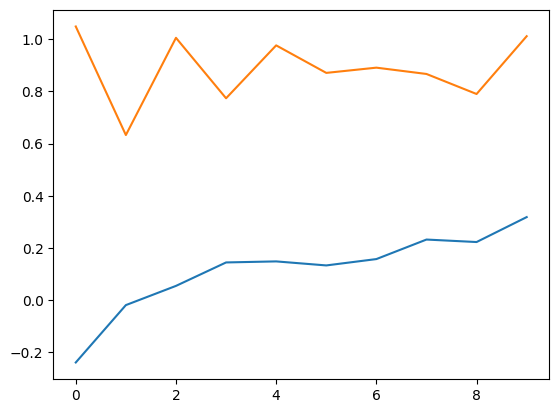

In [18]:
t10 = np.arange(10)
plt.plot(t10, means_50(y1_clean))
plt.plot(t10, vars_50(y1_clean))
plt.show()

In [19]:
print('y1 test:')
print(median_test(means_50(y1_clean)))
print(median_test(vars_50(y1_clean)))
print('y2 test:')
print(median_test(means_50(y2_clean)))
print(median_test(vars_50(y2_clean)))

y1 test:
3.06 4
3.42899024010167 4
False
3.06 9
3.42899024010167 2
True
y2 test:
3.06 6
3.42899024010167 3
True
3.06 6
3.42899024010167 3
True


In [39]:
def AKF(X, k):
    # Оценка автокорреляционной функции
    Rxx = 0
    mean_X = np.mean(X)
    var_X = np.var(X)
    for i in range(0, len(X) - abs(k)):
        Rxx += (X[i] - mean_X) * (X[i+k] - mean_X) / N
    return Rxx / (var_X + 0.0000001)

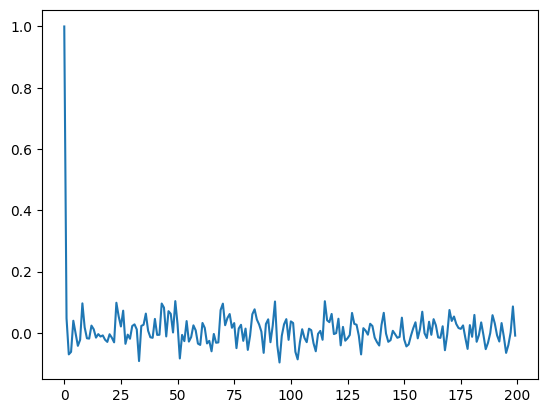

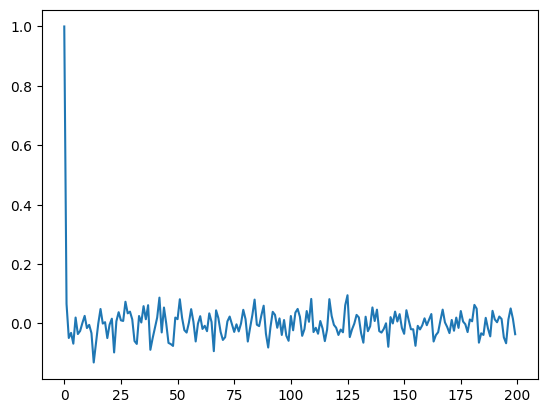

In [21]:
k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(y1_clean, i))
plt.plot(m, Rxx)
plt.show()

Rxx = []
for i in m:
    Rxx.append(AKF(y2_clean, i))
plt.plot(m, Rxx)
plt.show()

In [22]:
def SPM(X, k):
    # Оценка спектральной плотность мощности
    Ixx = 0
    delta = T / N

    Ixx_1 = 0
    Ixx_2 = 0

    for i in range(0, N):
        Ixx_1 += X[i] * np.cos((2 * np.pi * k * i) / N)
        Ixx_2 += X[i] * np.sin((2 * np.pi * k * i) / N)
    
    Ixx = delta / N * (Ixx_1 ** 2 + Ixx_2 ** 2)
    return Ixx
    

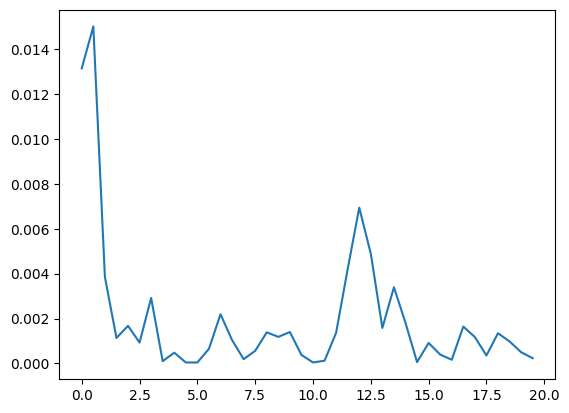

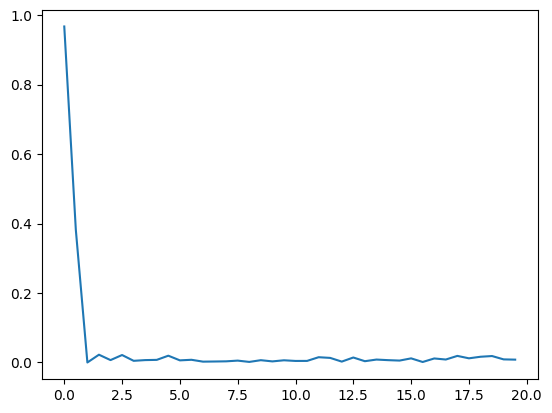

In [23]:
k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(y1_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

Sxx = []
for i in k:
    Sxx.append(SPM(y2_clean, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

<h3>4) Выделение и удаление тренда</h3>

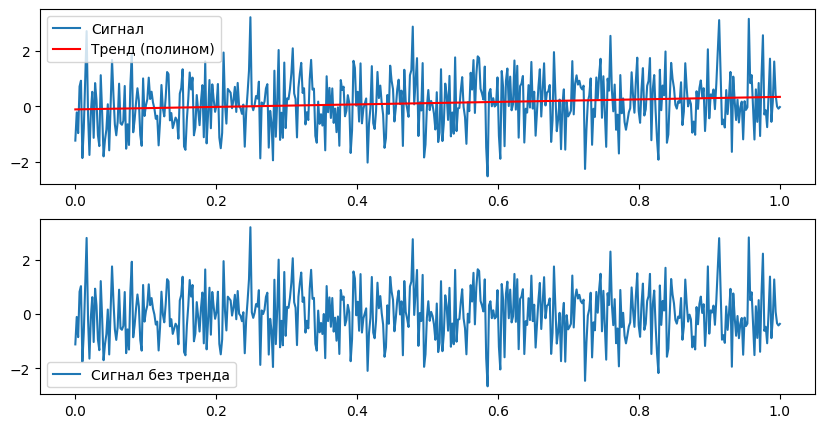

In [24]:
# степень полинома
degree = 1
coeffs = np.polyfit(t, y1_clean, degree)  # находим коэффициенты
trend = np.polyval(coeffs, t)      # считаем тренд

# удаляем тренд
detrended_y1 = y1_clean - trend

# визуализация
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, y1_clean, label="Сигнал")
plt.plot(t, trend, 'r', label="Тренд (полином)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, detrended_y1, label="Сигнал без тренда")
plt.legend()
plt.show()

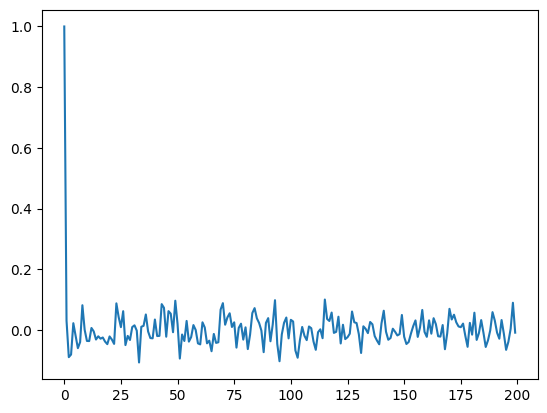

In [25]:
k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(detrended_y1, i))
plt.plot(m, Rxx)
plt.show()

In [26]:
print(f'С трендом: среднее = {np.mean(y1_clean)} скр = {np.sqrt(np.var(y1_clean))}')
print(f'После удаления: среднее = {np.mean(detrended_y1)} скр = {np.sqrt(np.var(detrended_y1))}')

С трендом: среднее = 0.11472074303492266 скр = 0.9532532290678523
После удаления: среднее = -2.842170943040401e-17 скр = 0.9443684814351249


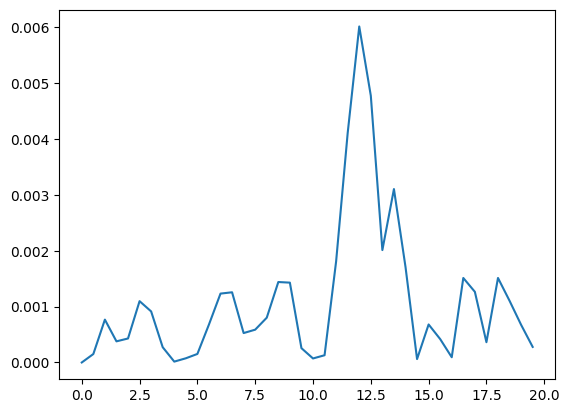

In [27]:
k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(detrended_y1, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

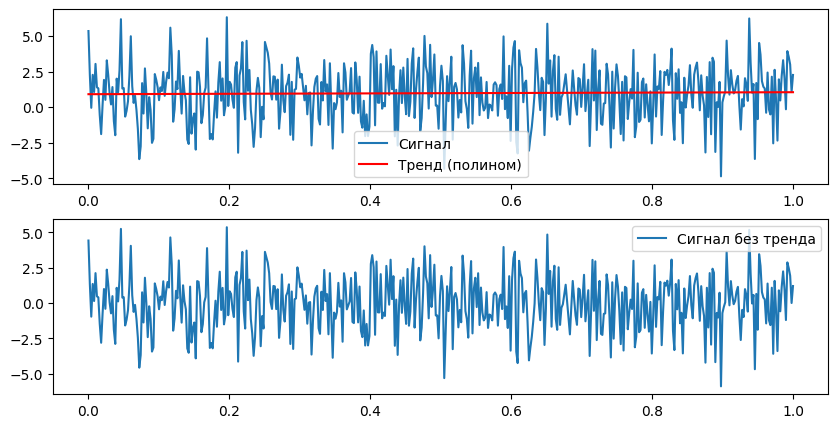

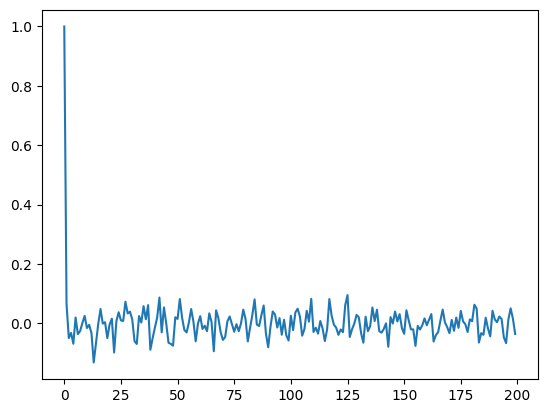

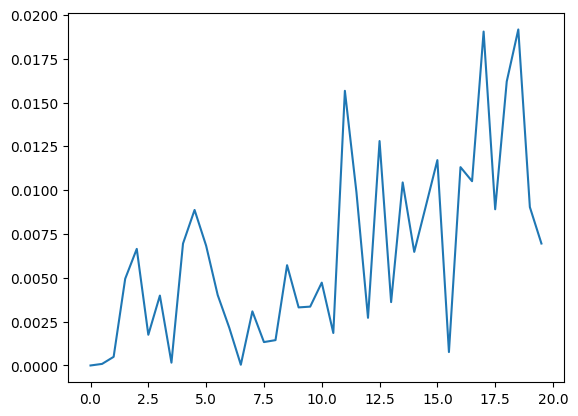

С трендом: среднее = 0.9836118279909665 скр = 1.9185518094538114
После удаления: среднее = -1.3500311979441903e-16 скр = 1.9181318709393411


In [28]:
# степень полинома
degree = 1
coeffs = np.polyfit(t, y2_clean, degree)  # находим коэффициенты
trend = np.polyval(coeffs, t)      # считаем тренд

# удаляем тренд
detrended_y2 = y2_clean - trend

# визуализация
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, y2_clean, label="Сигнал")
plt.plot(t, trend, 'r', label="Тренд (полином)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, detrended_y2, label="Сигнал без тренда")
plt.legend()
plt.show()

k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(detrended_y2, i))
plt.plot(m, Rxx)
plt.show()

k = np.arange(0, 20, 0.5)
f = k / T

Sxx = []

for i in k:
    Sxx.append(SPM(detrended_y2, i))
# print(Sxx[N])
plt.plot(f, Sxx)
plt.show()

print(f'С трендом: среднее = {np.mean(y2_clean)} скр = {np.sqrt(np.var(y2_clean))}')
print(f'После удаления: среднее = {np.mean(detrended_y2)} скр = {np.sqrt(np.var(detrended_y2))}')

In [29]:
from scipy import stats

stat, p = stats.shapiro(detrended_y1)  # Shapiro-Wilk тест
print("p-value =", p)

if p > 0.05:
    print("Не отвергаем гипотезу о номальности")
else:
    print("Отвергаем гипотезу о номальности")

stat, p = stats.shapiro(detrended_y2)  # Shapiro-Wilk тест
print("p-value =", p)

if p > 0.05:
    print("Не отвергаем гипотезу о номальности")
else:
    print("Отвергаем гипотезу о номальности")

p-value = 0.2250579428752335
Не отвергаем гипотезу о номальности
p-value = 0.44410498409163524
Не отвергаем гипотезу о номальности


<h3>5) АКФ И ВКФ для разных сигналов

In [46]:
def VKF(X, Y, k):
    # Оценка взаимной корреляционной функции
    Rxy = 0
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    std_X = np.std(X) + 0.0000001
    std_Y = np.std(Y)
    for i in range(0, len(X) - abs(k)):
        Rxy += (X[i] - mean_X) * (Y[i+k] - mean_Y) / N
    return Rxy / (std_X * std_Y)

<h4>Постоянный сигнал</h4>

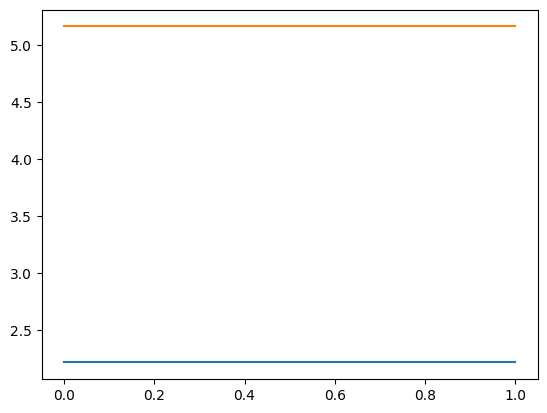

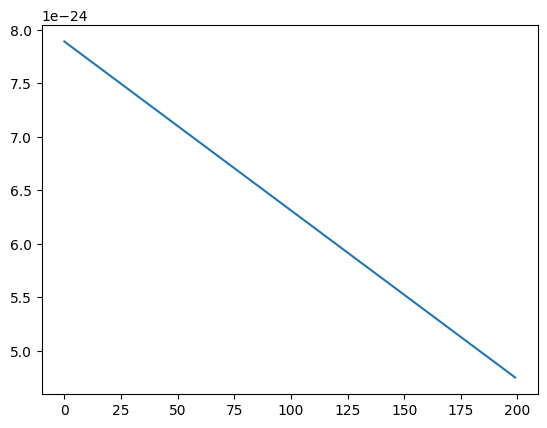

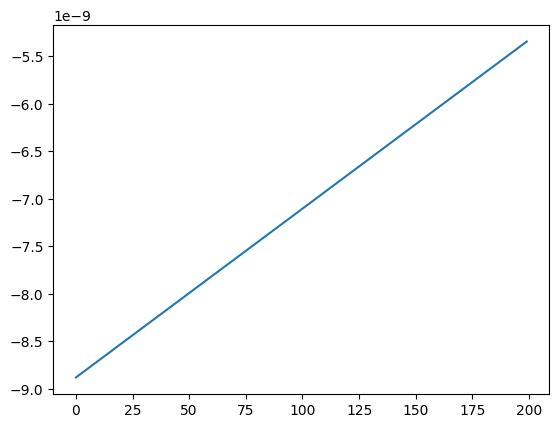

In [47]:
a1 =  np.random.uniform(1,10)
a2 = np.random.uniform(1,10)
signal1 = np.full(N, a1)
signal2 = np.full(N, a2)

t = np.linspace(0, T, N)

plt.plot(t, signal1)
plt.plot(t, signal2)
plt.show()

k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(signal1, i))
plt.plot(m, Rxx)
plt.show()

Rxy = []
for i in m:
    Rxy.append(VKF(signal1, signal2, i))
plt.plot(m, Rxy)
plt.show()

<h4>Белый шум

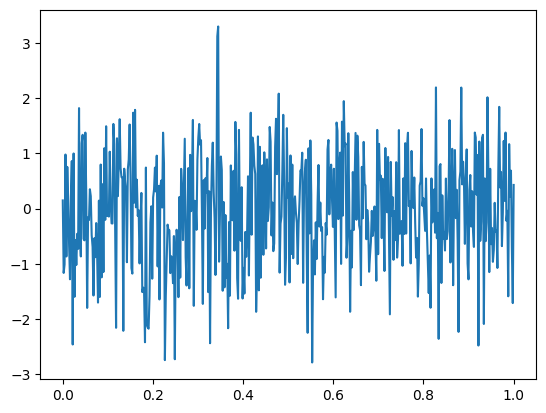

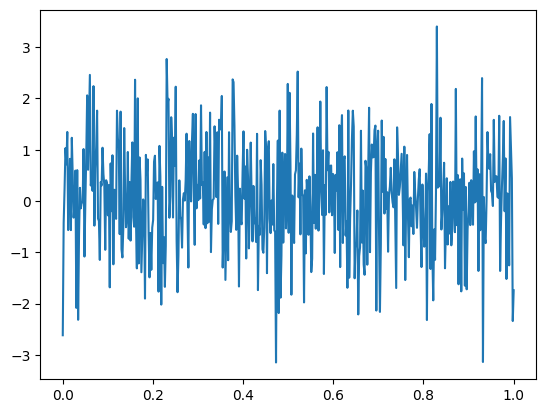

In [32]:
signal1 =  np.random.normal(loc=0, scale=1, size=N)
signal2 =  np.random.normal(loc=0, scale=1, size=N)

t = np.linspace(0, T, N)

plt.plot(t, signal1)
plt.show()
plt.plot(t, signal2)
plt.show()

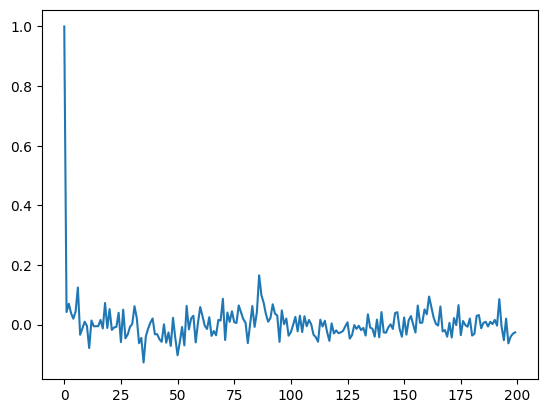

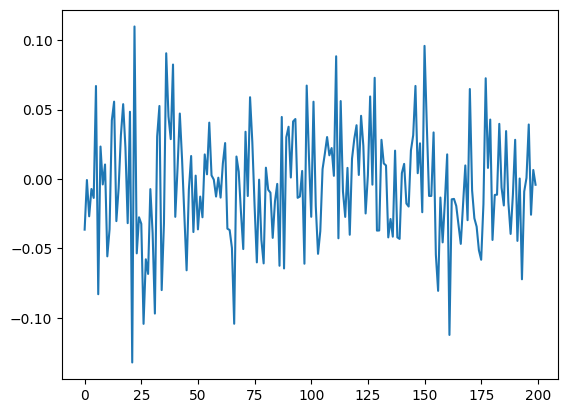

In [33]:
k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(signal1, i))
plt.plot(m, Rxx)
plt.show()

Rxy = []
for i in m:
    Rxy.append(VKF(signal1, signal2, i))
plt.plot(m, Rxy)
plt.show()

<h4>Несколько частотных составляющих</h4>

In [49]:
def sin_signal(f1, f2, f3, time):
    a1 = np.random.uniform(1,10)
    a2 = np.random.uniform(1,10)
    a3 = np.random.uniform(1,10)
    signal = []
    for t in time:
        signal.append(a1 * np.sin(f1 * 2 * np.pi * t) + a2 * np.sin(f2 * 2 * np.pi * t) + a3 * np.sin(f3 * 2 * np.pi * t))
    return signal

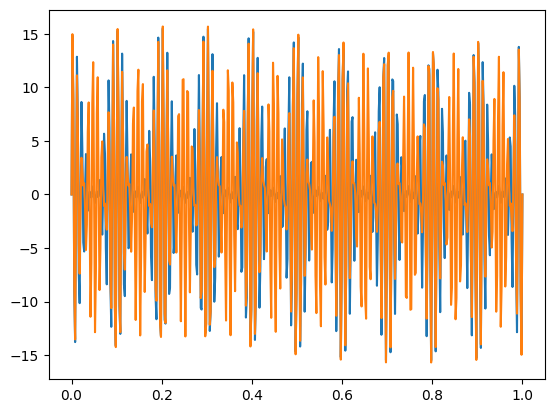

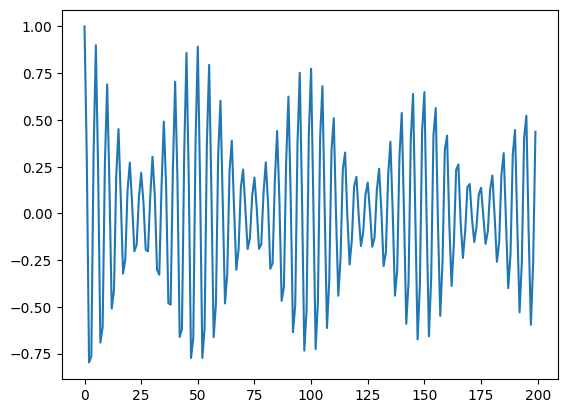

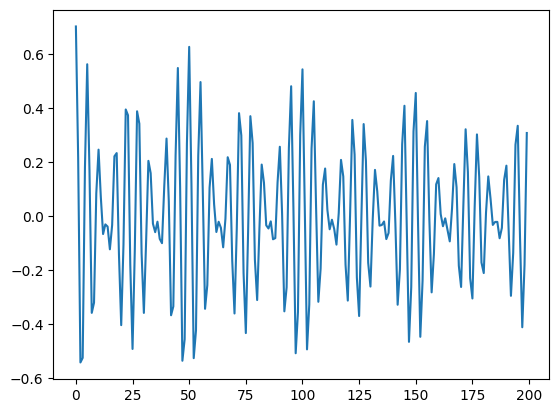

In [56]:
t = np.linspace(0, T, N)

signal1 = sin_signal(90, 100, 110, t)
signal2 = sin_signal(90, 100, 110, t)

plt.plot(t, signal1)
plt.plot(t, signal2)
plt.show()

k = 200
m = np.arange(k)
Rxx = []

for i in m:
    Rxx.append(AKF(signal1, i))
plt.plot(m, Rxx)
plt.show()

Rxy = []
for i in m:
    Rxy.append(VKF(signal1, signal2, i))
plt.plot(m, Rxy)
plt.show()

<h3>7) СПМ и ВСПМ для двух синусов

In [34]:
def signal1(t, e):
    return 2*np.sin(102*t*2*np.pi)+1.7*np.sin(102.08*t*2*np.pi)+2.3*np.sin(110*t*2*np.pi)+0.2*e
def signal2(t,e):
    return 1.6*np.sin(102.8*t*2*np.pi)+2.1*np.sin(110*t*2*np.pi)+2.0*np.sin(210*t*2*np.pi)+0.2*e

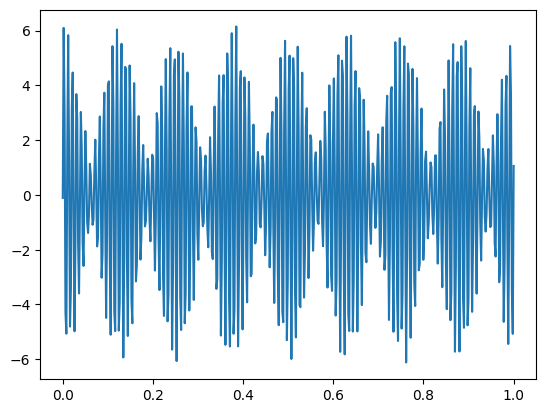

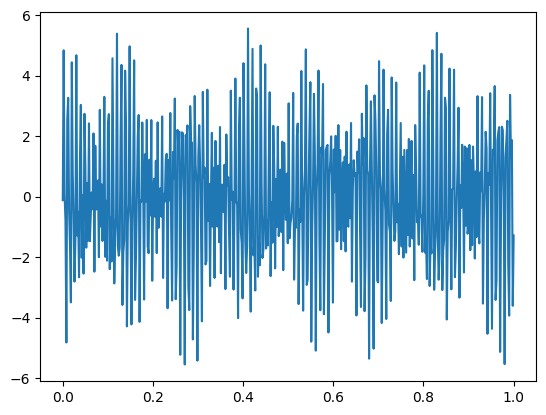

In [35]:
e = np.random.normal(loc=0, scale=1, size=N)
signal_x = []
signal_y = []

for i in range(N):
    signal_x.append(signal1(t[i], e[i]))
    signal_y.append(signal2(t[i], e[i]))
    
plt.plot(t, signal_x)
plt.show()
plt.plot(t, signal_y)
plt.show()

[102.0, 102.5, 110.0, 110.5]


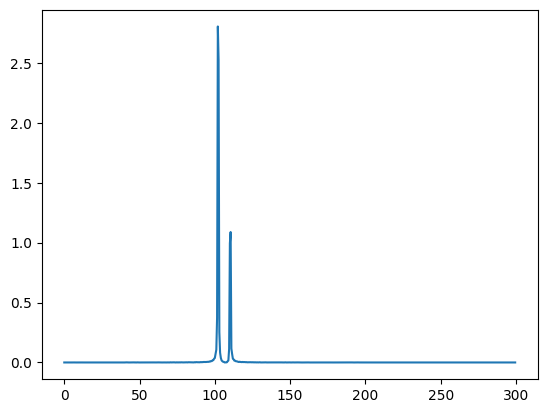

[103.0, 110.0, 110.5, 210.0, 210.5, 289.5, 290.0]


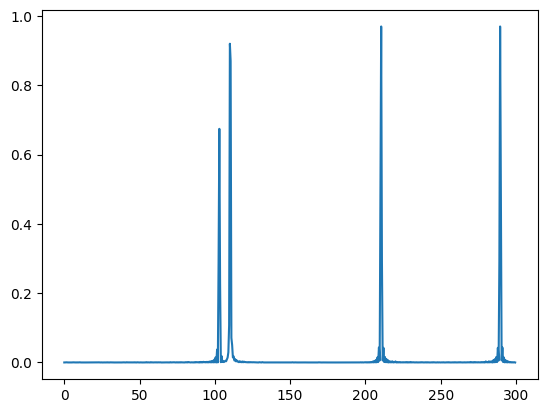

In [36]:
k = np.arange(0, 300, 0.5)
f = k / T

Sxx = []
freqs = []
l = 0
for i in k:
    Sxx.append(SPM(signal_x, i))
    if Sxx[l] > 0.5:
        freqs.append(i)
    l += 1
print(freqs)
plt.plot(f, Sxx)
plt.show()

Sxx = []
freqs = []
l = 0
for i in k:
    Sxx.append(SPM(signal_y, i))
    if Sxx[l] > 0.5:
        freqs.append(i)
    l += 1
print(freqs)
plt.plot(f, Sxx)
plt.show()